### Model Selection
El objetivo de este notebook es realizar la evaluación de cada modelo y decicir con cual se procede para la hiperaparametrización. 

#### Carga de paquetes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

#### Configuracion

In [2]:
np.random.seed(0)

In [3]:
pd.set_option("display.max_columns", None)

 #### Helpers

In [4]:
def plot_confusion_matrix(cm: np.ndarray, classes: list):
    """
    Plots a confusion matrix.

    Args:
        cm (np.ndarray): The confusion matrix.
        classes (list): The class labels.

    Returns:
        None
    """
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()


def plot_roc_curve(y_test: np.ndarray, y_proba: np.ndarray):
    """
    Plots the ROC curve.

    Args:
        y_test (np.ndarray): The true labels.
        y_proba (np.ndarray): The predicted probabilities.

    Returns:
        None
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label="ROC Curve (AUC = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

#### Cargamos los datos

In [5]:
# Importamos el dataset de features
df = pd.read_csv("test.csv")
df.shape

(3000, 26)

In [6]:
df.drop(
    columns=[
        "invoiceId",
        "businessId",
        "payerId",
        "mora",
        "auxAmountFactura",
        "payerNroMorosidad",
        "payerNroFacturas",
        "payerAmount",
        "payerDiasMora",
        "businessNroMorosidad",
        "businessNroFacturas",
        "businessDiasMora",
    ],
    inplace=True,
)

In [7]:
# df = df[['montoFactura', 'relationDays',
#       'relationRecurrence', 'issuerInvoicesAmount', 'issuerCancelledInvoices',
#       'diasActividadPagador', 'Clients12Months', 'moroso']].copy()

In [8]:
df.head()

,montoFactura,relationDays,relationRecurrence,issuerInvoicesAmount,issuerCancelledInvoices,diasActividadPagador,Clients12Months,moroso,payerRateMororsidad,payerAvgAmount,payerAvgDiasMora,payerDesvAmount,businessRateMororsidad,businessAvgDiasMora
2186,4713103,428.0,10.166667,187036960,0.021942,2632.0,4,1,0.400000,4035767,2.266667,677336,0.000000,0.000000
2819,7879645,455.0,9.891304,231623853,0.020079,2659.0,4,0,0.423077,4055029,2.865385,3824616,1.000000,18.000000
2713,1190417,493.0,9.264151,272695026,0.016629,2697.0,4,1,0.348485,3962206,6.348485,-2771789,0.500000,6.000000
1141,189924,542.0,9.016667,321318559,0.014322,2746.0,3,0,0.375000,3862669,7.041667,-3672745,0.666667,4.333333
2301,3755846,562.0,8.920635,346234215,0.013314,2766.0,3,0,0.376623,3863075,6.181818,-107229,0.500000,3.250000


#### División del conjunto de entrenamiento

In [9]:
# Especificar las características (X) y el objetivo (y)
x = df.drop(columns=["moroso"], axis=1)
y = df["moroso"]

# Supongamos que x son las características y y es la variable objetivo
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=22
)

# Ahora, dividimos el conjunto de prueba en conjuntos de prueba y validación, asignando el 10% del conjunto original a cada uno.
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=22
)

# Verificamos las formas de los conjuntos resultantes
print("Formas de los conjuntos:")
print("Entrenamiento:", x_train.shape, y_train.shape)
print("Prueba:", x_test.shape, y_test.shape)
print("Validación:", x_val.shape, y_val.shape)


# Mostrar las formas de las particiones
print("Forma de x_train:", x_train.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Formas de los conjuntos:
Entrenamiento: (2700, 13) (2700,)
Prueba: (150, 13) (150,)
Validación: (150, 13) (150,)
Forma de x_train: (2700, 13)
Forma de x_val: (150, 13)
Forma de x_test: (150, 13)
Forma de y_train: (2700,)
Forma de y_val: (150,)
Forma de y_test: (150,)


In [10]:
# Creamos un diccionario donde guardamos todo el conjunto de datos
datasets = {
    "train": (x_train, y_train),
    "test": (x_test, y_test),
    "val": (x_val, y_val),
}

#### Evaluamos distintos modelos

##### Funciones de entrenamiento y evaluación

In [11]:
def track_metrics(
    pipeline,
    x: np.ndarray,
    y: np.ndarray,
    set_name: str = "test",
    threshold: float = 0.5,
):
    """
    Tracks metrics for a classification pipeline.

    Args:
        pipeline: The classification pipeline.
        x (np.ndarray): The input features.
        y (np.ndarray): The true labels.
        set_name (str): The name of the dataset (default: "test").
        threshold (float): The threshold for prediction (default: 0.5).

    Returns:
        None
    """
    # Predict probabilities
    y_proba = pipeline.predict_proba(x)[:, 1]

    # Apply the threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Calculate metrics
    cm = confusion_matrix(y, y_pred)
    auc_roc = roc_auc_score(y, y_proba)

    # Print auc-roc
    print(f"Auc Roc: {auc_roc}")

    # Get the best threshold
    fpr, tpr, thresholds = roc_curve(y, y_proba)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Umbral óptimo: {optimal_threshold:.4f}")

    # Print classification report
    report = classification_report(y, y_pred, target_names=["Negative", "Positive"])
    print(f"Classification Report:\n{report}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(cm, classes=["Negative", "Positive"])

    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plot_roc_curve(y, y_proba)

In [12]:
def run_experiments(models: list, datasets: dict, run_params: dict = None):
    """
    Runs experiments for multiple models.

    Args:
        models (list): A list of tuples containing the model class and model parameters.
        datasets (dict): A dictionary containing the datasets for training, testing, and validation.
        run_params (dict): Additional parameters for the experiment runs (default: None).

    Returns:
        None
    """
    x_train, y_train = datasets["train"]
    x_test, y_test = datasets["test"]
    x_val, y_val = datasets["val"]

    for model in models:
        # Initialize the run
        model_name = model.__name__
        print("=" * 78)
        print(f"Starting experiment for model: {model_name}.")
        print("=" * 78)

        try:
            print("Training the model...")
            steps = [("scaler", StandardScaler()), ("model", model())]
            pipeline = Pipeline(steps=steps)

            # Train the model
            pipeline.fit(x_train, y_train)

            print("METRICS ON TESTING SET", "=" * 58)
            track_metrics(
                pipeline,
                x_test,
                y_test,
                set_name="test",
                threshold=run_params["threshold"],
            )

            print("METRICS ON VALIDATION", "=" * 55)
            track_metrics(
                pipeline,
                x_val,
                y_val,
                set_name="val",
                threshold=run_params["threshold"],
            )

        except Exception as e:
            # Handle any exception and log the error
            print(e)

        finally:
            print("Experiment completed.")

##### Configuración de los parámetros de balanceo de datos

In [13]:
# Para remover el sampleo remplazar los string con None
params = {
    "threshold": 0.5,
}

##### Corridas de diferentes modelos

In [14]:
df.moroso.value_counts(normalize=True)

moroso
0    0.598667
1    0.401333
Name: proportion, dtype: float64

Starting experiment for model: LogisticRegression.
Training the model...
METRICS ON TESTING SET ==========================================================
Auc Roc: 0.7449773755656108
Umbral óptimo: 0.3570
Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.86      0.75        85
    Positive       0.70      0.43      0.53        65

    accuracy                           0.67       150
   macro avg       0.68      0.64      0.64       150
weighted avg       0.68      0.67      0.66       150



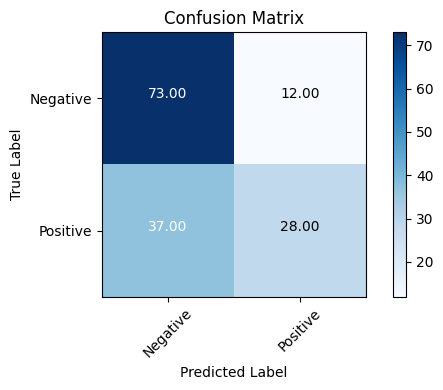

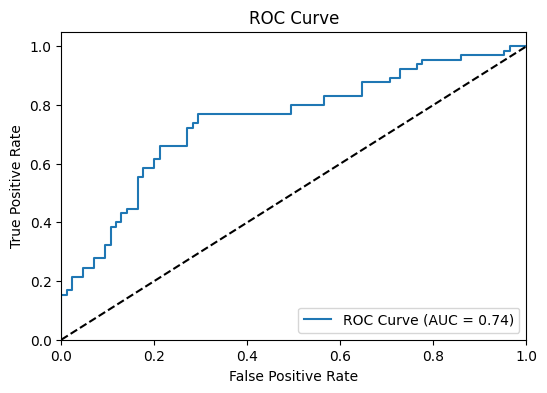

METRICS ON VALIDATION =======================================================
Auc Roc: 0.6625180375180375
Umbral óptimo: 0.4184
Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.81      0.72        84
    Positive       0.64      0.42      0.51        66

    accuracy                           0.64       150
   macro avg       0.64      0.62      0.61       150
weighted avg       0.64      0.64      0.62       150



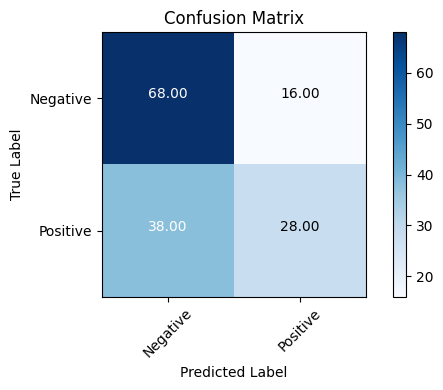

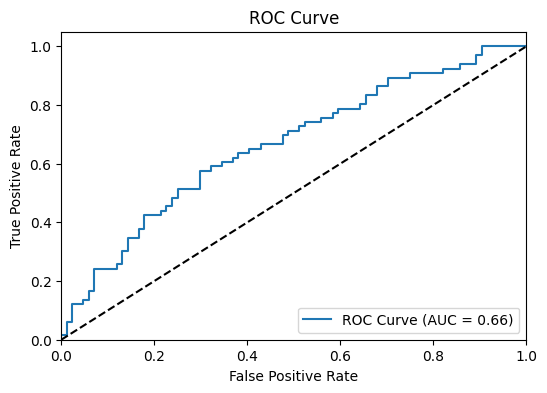

Experiment completed.
Starting experiment for model: XGBClassifier.
Training the model...
METRICS ON TESTING SET ==========================================================
Auc Roc: 0.7431674208144797
Umbral óptimo: 0.3697
Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.79      0.74        85
    Positive       0.66      0.54      0.59        65

    accuracy                           0.68       150
   macro avg       0.68      0.66      0.66       150
weighted avg       0.68      0.68      0.67       150



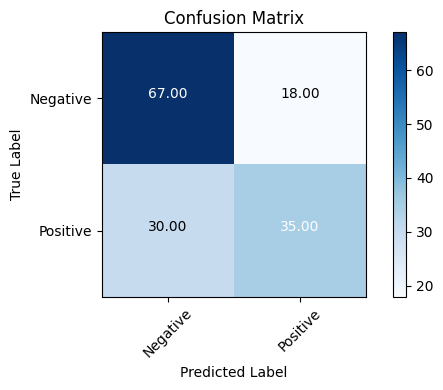

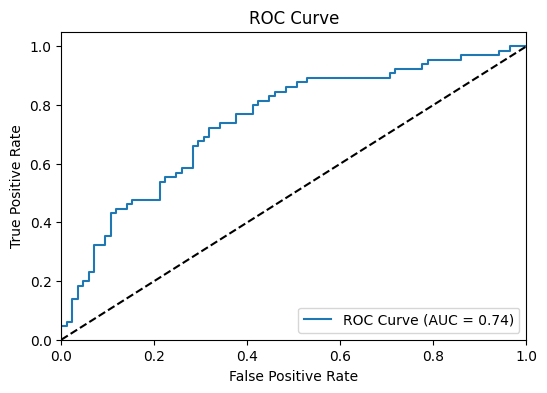

METRICS ON VALIDATION =======================================================
Auc Roc: 0.7106782106782107
Umbral óptimo: 0.3538
Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.77      0.73        84
    Positive       0.67      0.58      0.62        66

    accuracy                           0.69       150
   macro avg       0.68      0.67      0.68       150
weighted avg       0.68      0.69      0.68       150



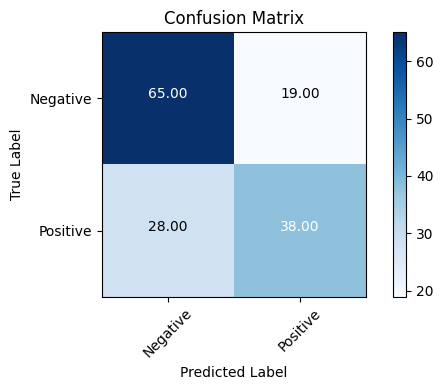

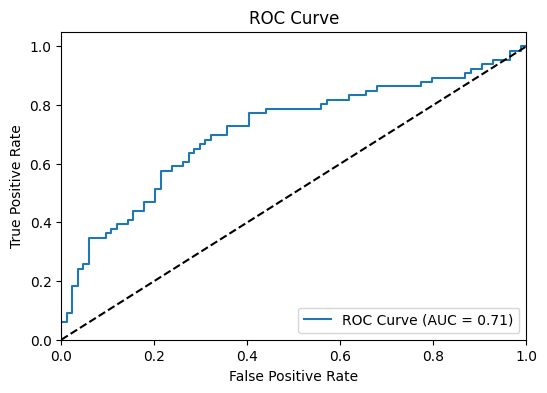

Experiment completed.


In [15]:
models = [LogisticRegression, XGBClassifier]

run_experiments(models, datasets, params)

**Importante:**

Los resultados del experimentos fueron mejor de lo esperado. Este resultado hay que analizarlo cuidadosamente. Tenemos varios indicios de que podríamos estar overfitteando por lo que habría que seguir trabajando los datos para analizar se si puede evitar este problema.

A modos ilustrativos para generar la implementación del modelo vamos a seleccionar el XGBoost para continuar con el trabajo. Ahora vamos a entrenar nuevamente el modelo para ver las métricas utilizando el umbral que máximice la performance del modelo.